## Distribución Normal: simulación y recuperación de parámetros

En este apunte mostramos cómo calcular distribuciones posteriores sobre los parámetros de una distribución Normal utilizando `JAGS`. 

Comenzamos simulando observaciones normales con media y desviación estándar conocidas para después interpretar dichas simulaciones como mediciones reales y estudiar el resultado que devuelve el algoritmo de sampleo.

#### Primera parte: Simulación

Para generar nuestras "mediciones" inventadas elegiremos valores de la media $\mu$, y de la desviación estándar $\sigma$, totalmente arbitrarios, y utilizaremos la función en `R` que permite simular observaciones desde una distribución Normal.

En este sentido, _sabemos_ que nuestro vector `norm_simul` proviene, o fue generado, por cierta densidad específica, y también conocemos los valores paramétricos precisos, sin incertidumbre, de dicha densidad:

$$norm simul\sim Gaussian(\mu=160,\sigma=10)$$

In [3]:
rm(list=ls())
true_mean <- 160
true_sd <- 10
set.seed(123)
norm_simul <- rnorm(n = 35, mean = true_mean, sd = true_sd) # R parametriza la Normal con (media y) DESVIACIÓN.
round(norm_simul,2)

[1] 154.40 157.70 175.59 160.71 161.29 177.15 164.61 147.35 153.13 155.54
[11] 172.24 163.60 164.01 161.11 154.44 177.87 164.98 140.33 167.01 155.27
[21] 149.32 157.82 149.74 152.71 153.75 143.13 168.38 161.53 148.62 172.54
[31] 164.26 157.05 168.95 168.78 168.22

In [4]:
summary(norm_simul)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  140.3   154.1   161.1   160.4   167.6   177.9 

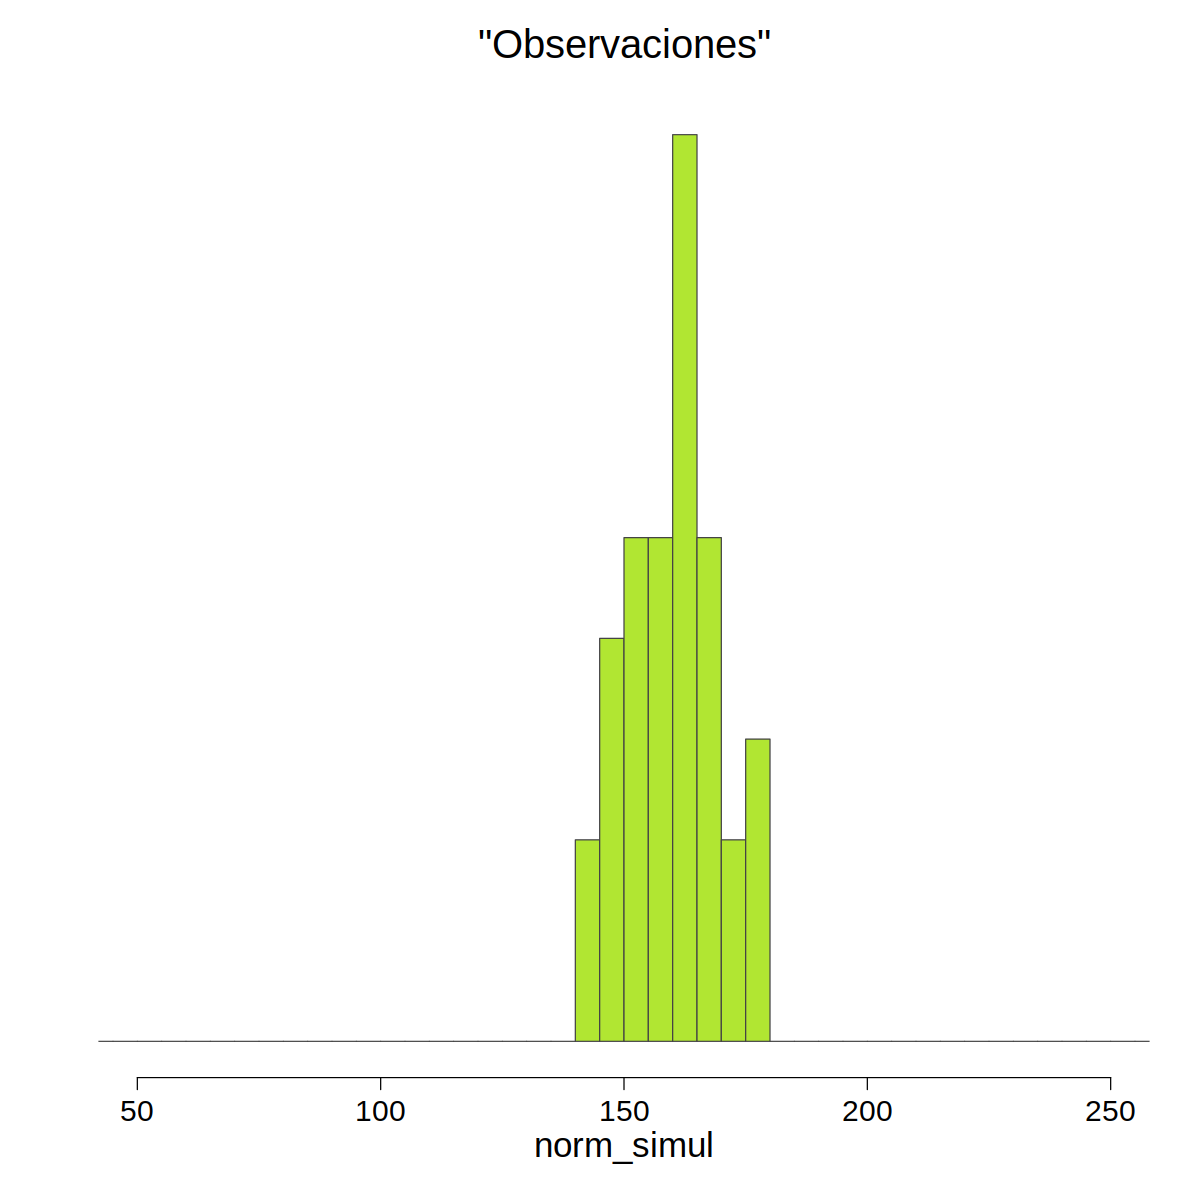

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10) # Plot size in notebook
col_data <- "#b1e632"
col_true <- '#912cee'
hist(norm_simul,xlim=c(50,250),breaks=seq(0,300,5),col=col_data,border='#444444',axes=F,ann=F)->ht
axis(1,cex.axis=1.5)
mtext('"Observaciones"',3,cex=2,line=1.5)
mtext('norm_simul',1,cex=1.75,line=2.5)

#### Segunda parte: Recuperación de parámetros

A partir de este punto interpretaremos nuestro vector simulado como si se tratara de un conjunto de mediciones recolectadas en el mundo real. En este escenario "olvidaremos" que conocemos los valores de $\mu$  y $\sigma$ que generaron las observaciones e intentaremos inferir su valor utilizando las técnicas de inferencia presentadas en el curso.

Idealmente esperamos que las técnicas de inferencia empleadas nos llevan a conclusiones cercanas a la "verdad latente" con la que generamos los valores simulados; si esto no ocurre incluso cuando tenemos control absoluto sobre el modelo y los parámetros responsables de ciertas observaciones, no podemos confiar en las técnicas de inferencia en escenarios reales en los que la verdad latente es fundamentalmente inobservable.

En otras palabras, el _recuperar parámetros_ es un método que permite evaluar la consistencia entre el modelo, los datos, y las técnicas de inferencia que aplicamos entre ellos.

In [4]:
# Observed
n_obs <- length(norm_simul)
data_jags <- list('norm_simul','n_obs')

# Unobserved
unobs <- c('mean_prior','mean_post',
          'sd_prior','sd_post',
          'precision_prior','precision_post',
          'norm_simul_prior','norm_simul_post')

# Model
write('

model{

    mean_prior~dunif(100,200)
    mean_post~dunif(100,200)
    sd_prior~dunif(0,20)
    sd_post~dunif(0,20)
    precision_prior <- 1/sd_prior^2
    precision_post <- 1/sd_post^2

    for(i in 1:n_obs){
        norm_simul[i]~dnorm(mean_post,precision_post) # JAGS parametriza la Normal con (media y) PRECISIÓN.
    }

    norm_simul_post~dnorm(mean_post,precision_post) # JAGS parametriza la Normal con (media y) PRECISIÓN.
    norm_simul_prior~dnorm(mean_prior,precision_prior) # JAGS parametriza la Normal con (media y) PRECISIÓN.

}

','recovering_parameters.bug')

library('R2jags')
bayes <- jags(data=data_jags,
             parameters.to.save=unobs,
             model.file='recovering_parameters.bug',
             n.iter=10000,
             n.burnin=8000,
             n.thin=1)
nds <- bayes$BUGSoutput$sims.list

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 35
   Unobserved stochastic nodes: 6
   Total graph size: 52

Initializing model



Nota que la _única_ información que alimentamos a `JAGS` son las observaciones simuladas, pero en ningún momento hacemos explícitos los valores "verdaderos" de $\mu$ ni de $\sigma$.

Además, es **muy importante** señalar que la densidad Normal en `JAGS` funciona ligeramente diferente a la misma densidad en `R`. En concreto, la densidad normal en `R` se parametriza en términos de la media $\mu$ y de la desviación estándar $\sigma$ (línea 5 de la primera célula), mientras que en `JAGS` la normal se parametriza en términos de la misma media $\mu$ y de la precisión $\lambda$, que es otra manera de expresar la dispersión de esta densidad:

$$\lambda=\frac{1}{\sigma^2}$$

Esta distinción es importante a la hora de interpretar los resultados que regresa `JAGS` acerca del segundo parámetro dentro de `dnorm()`: dichos resultados _siempre_ estarán en escala de $\lambda$ y para interpretarlos en escala de $\sigma$ es necesario incluir la "traducción" correspondiente (líneas 19 y 20 de la célula anterior).

Una vez que el `JAGS` devuelve la aproximación numérica a las posteriores de interés podemos compararlas contra los valores verdaderos que generaron nuestras observaciones:

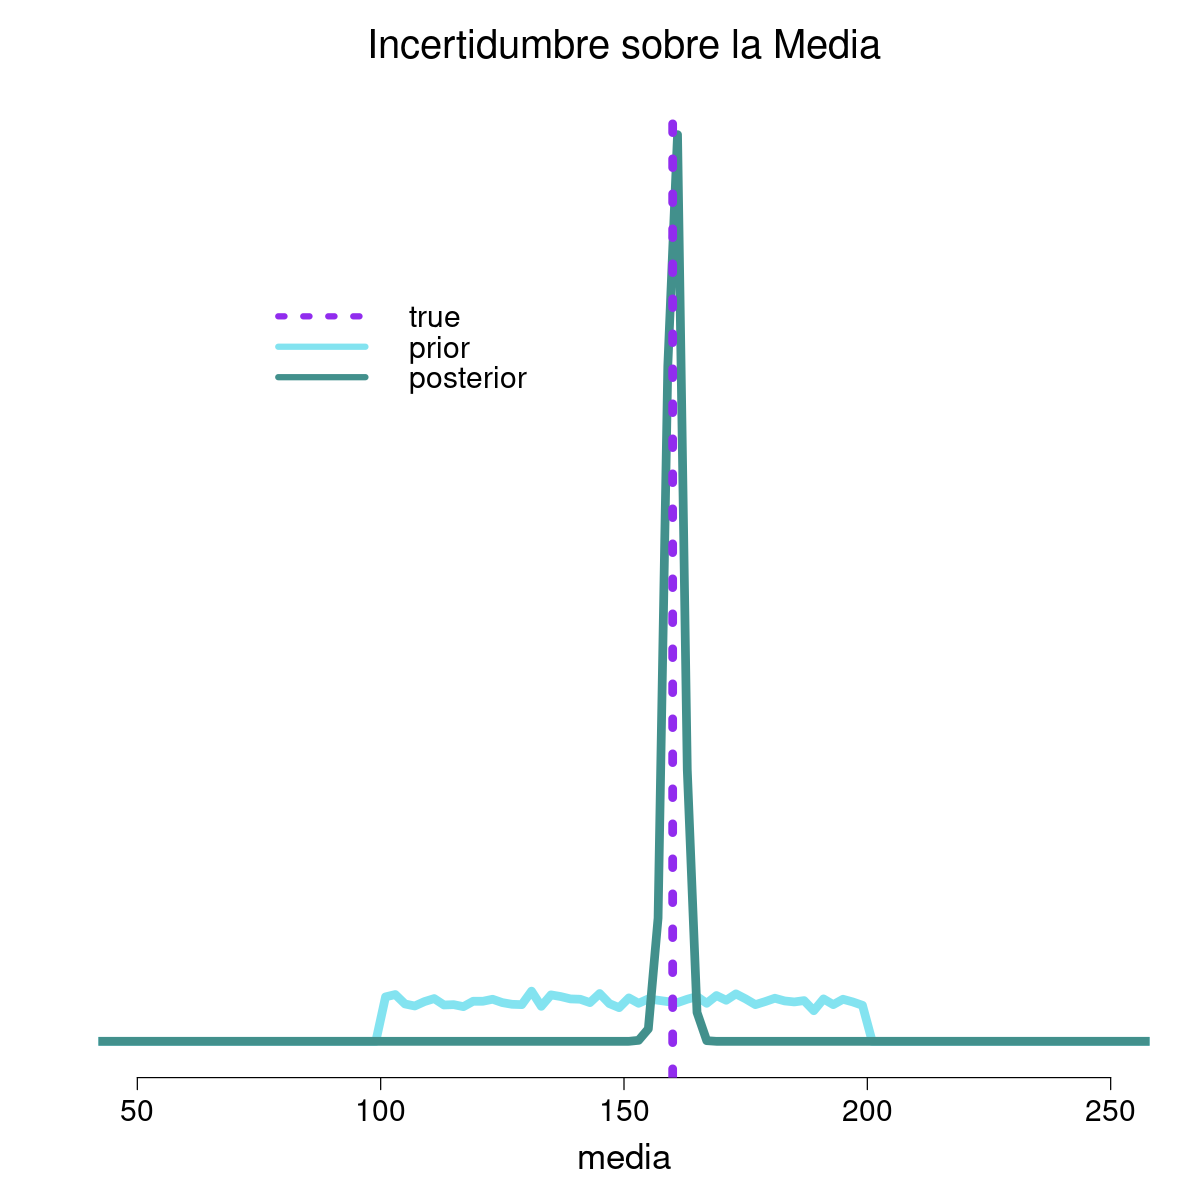

In [5]:
col_prior <- '#83e3f0'
col_post <- '#42908c'
hist(nds$mean_post,breaks=seq(0,300,2),plot=F)-> ht_mu_post
hist(nds$mean_prior,breaks=seq(0,300,2),plot=F)-> ht_mu_prior
plot(NULL,xlim=c(50,250),ylim=c(0,max(max(ht_mu_post$density),max(ht_mu_prior$density))),ann=F,axes=F)
axis(1,cex.axis=1.5)
mtext('Incertidumbre sobre la Media',3,cex=2,line=1.5)
mtext('media',1,cex=1.75,line=3)
lines(ht_mu_prior$mids,ht_mu_prior$density,col=col_prior,lwd=7)
lines(ht_mu_post$mids,ht_mu_post$density,col=col_post,lwd=7)
abline(v=true_mean,col=col_true,lwd=7,lty='dotted')
legend(70,max(max(ht_mu_post$density),max(ht_mu_prior$density))*.85,
      legend=c('true','prior','posterior'),
      lwd=5,col=c(col_true,col_prior,col_post),lty=c('dotted','solid','solid'),
       cex=1.5,y.intersp=.5,box.lty='blank')

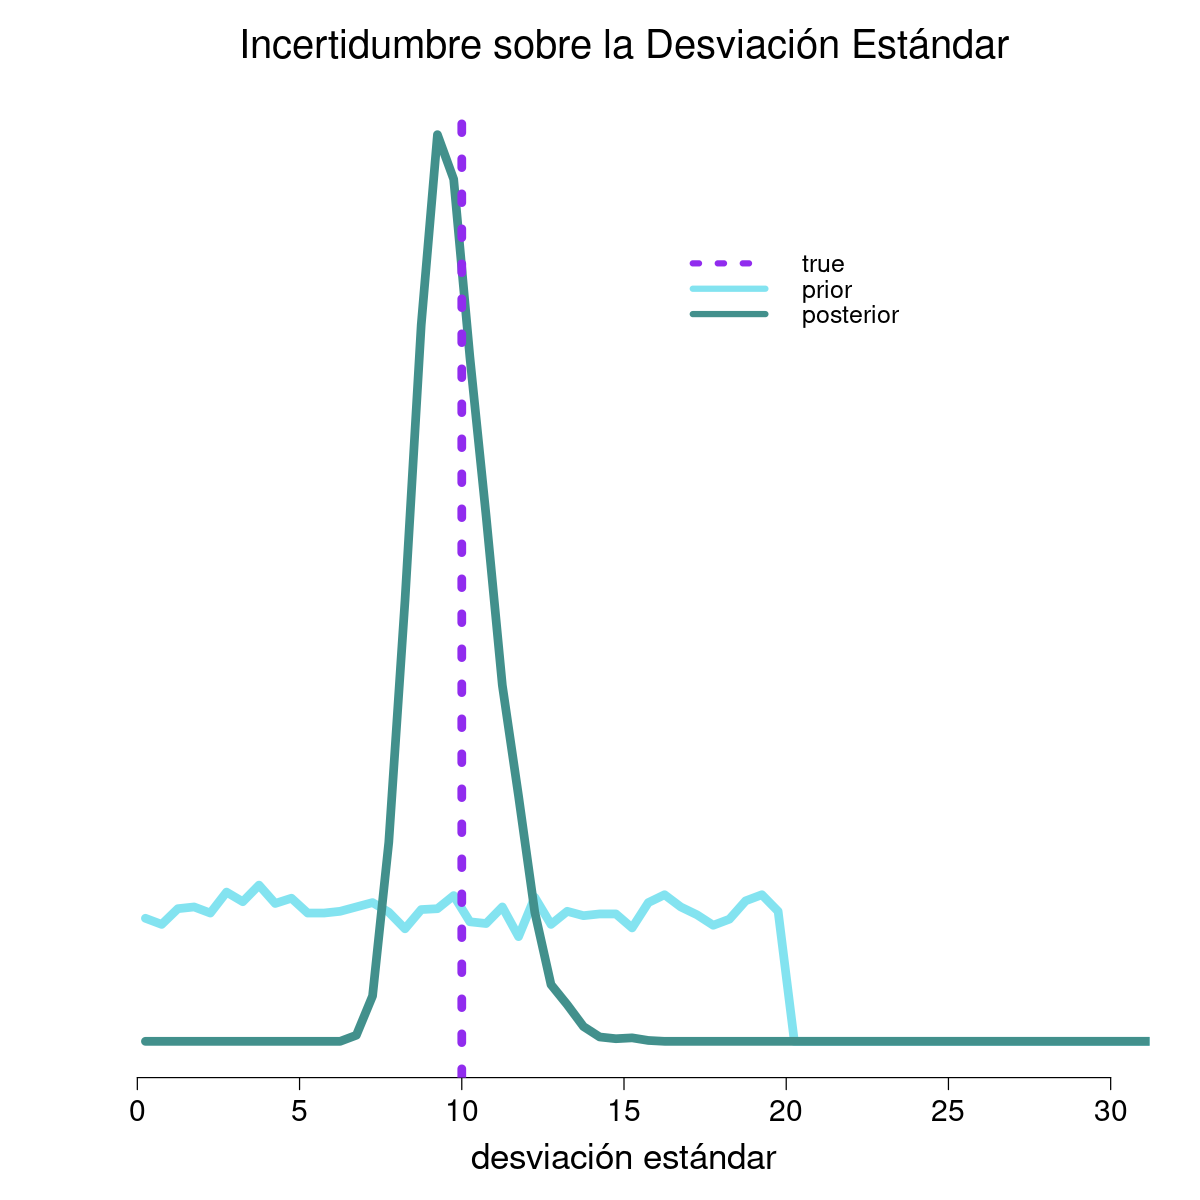

In [6]:
hist(nds$sd_post,breaks=seq(0,50,.5),plot=F)-> ht_sd_post
hist(nds$sd_prior,breaks=seq(0,50,.5),plot=F)-> ht_sd_prior
plot(NULL,xlim=c(0,30),ylim=c(0,max(max(ht_sd_post$density),max(ht_sd_prior$density))),ann=F,axes=F)
axis(1,cex.axis=1.5)
mtext('Incertidumbre sobre la Desviación Estándar',3,cex=2,line=1.5)
mtext('desviación estándar',1,cex=1.75,line=3)
lines(ht_sd_prior$mids,ht_sd_prior$density,col=col_prior,lwd=7)
lines(ht_sd_post$mids,ht_sd_post$density,col=col_post,lwd=7)
abline(v=true_sd,col=col_true,lwd=7,lty='dotted')
legend(16,max(max(ht_sd_post$density),max(ht_sd_prior$density))*.9,
      legend=c('true','prior','posterior'),
      lwd=5,col=c(col_true,col_prior,col_post),lty=c('dotted','solid','solid'),
       cex=1.25,y.intersp=.5,box.lty='blank')

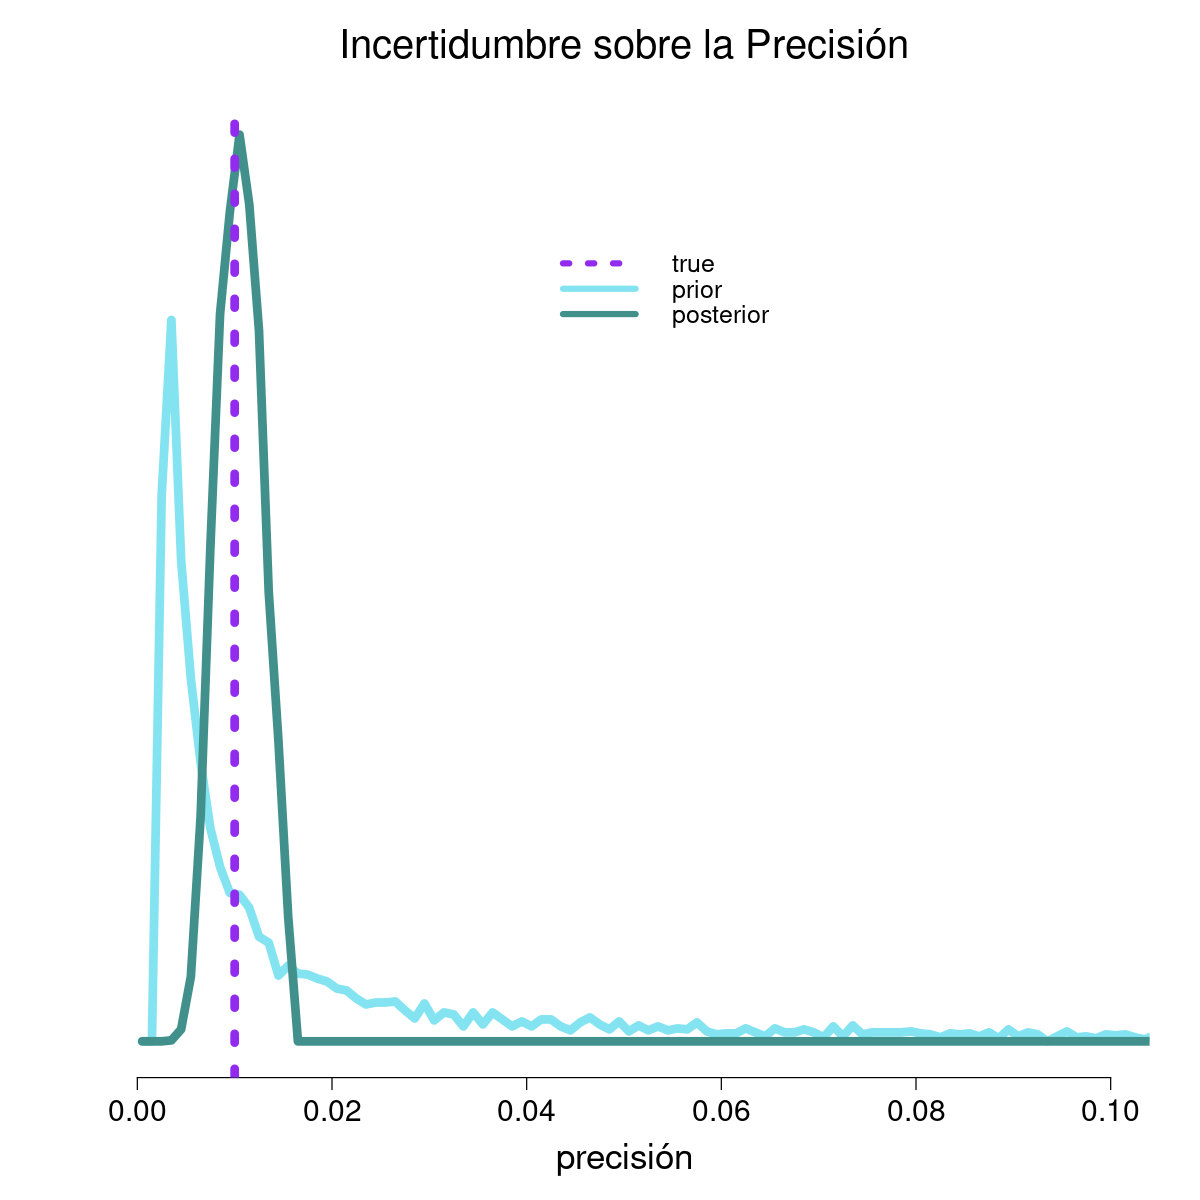

In [7]:
prec_post_plot <- nds$precision_post[nds$precision_post<quantile(nds$precision_post,0.95)]
prec_prior_plot <- nds$precision_prior[nds$precision_prior<quantile(nds$precision_prior,0.95)]
hist(prec_post_plot,breaks=seq(0,5,0.001),plot=F)-> ht_precision_post
hist(prec_prior_plot,breaks=seq(0,5,0.001),plot=F)-> ht_precision_prior
plot(NULL,xlim=c(0,.1),ylim=c(0,max(max(ht_precision_post$density),max(ht_precision_prior$density))),ann=F,axes=F)
axis(1,cex.axis=1.5)
mtext('Incertidumbre sobre la Precisión',3,cex=2,line=1.5)
mtext('precisión',1,cex=1.75,line=3)
lines(ht_precision_prior$mids,ht_precision_prior$density,col=col_prior,lwd=7)
lines(ht_precision_post$mids,ht_precision_post$density,col=col_post,lwd=7)
abline(v=1/true_sd^2,col=col_true,lwd=7,lty='dotted')
legend(0.04,max(max(ht_precision_post$density),max(ht_precision_prior$density))*.9,
      legend=c('true','prior','posterior'),
      lwd=5,col=c(col_true,col_prior,col_post),lty=c('dotted','solid','solid'),
       cex=1.25,y.intersp=.5,box.lty='blank')

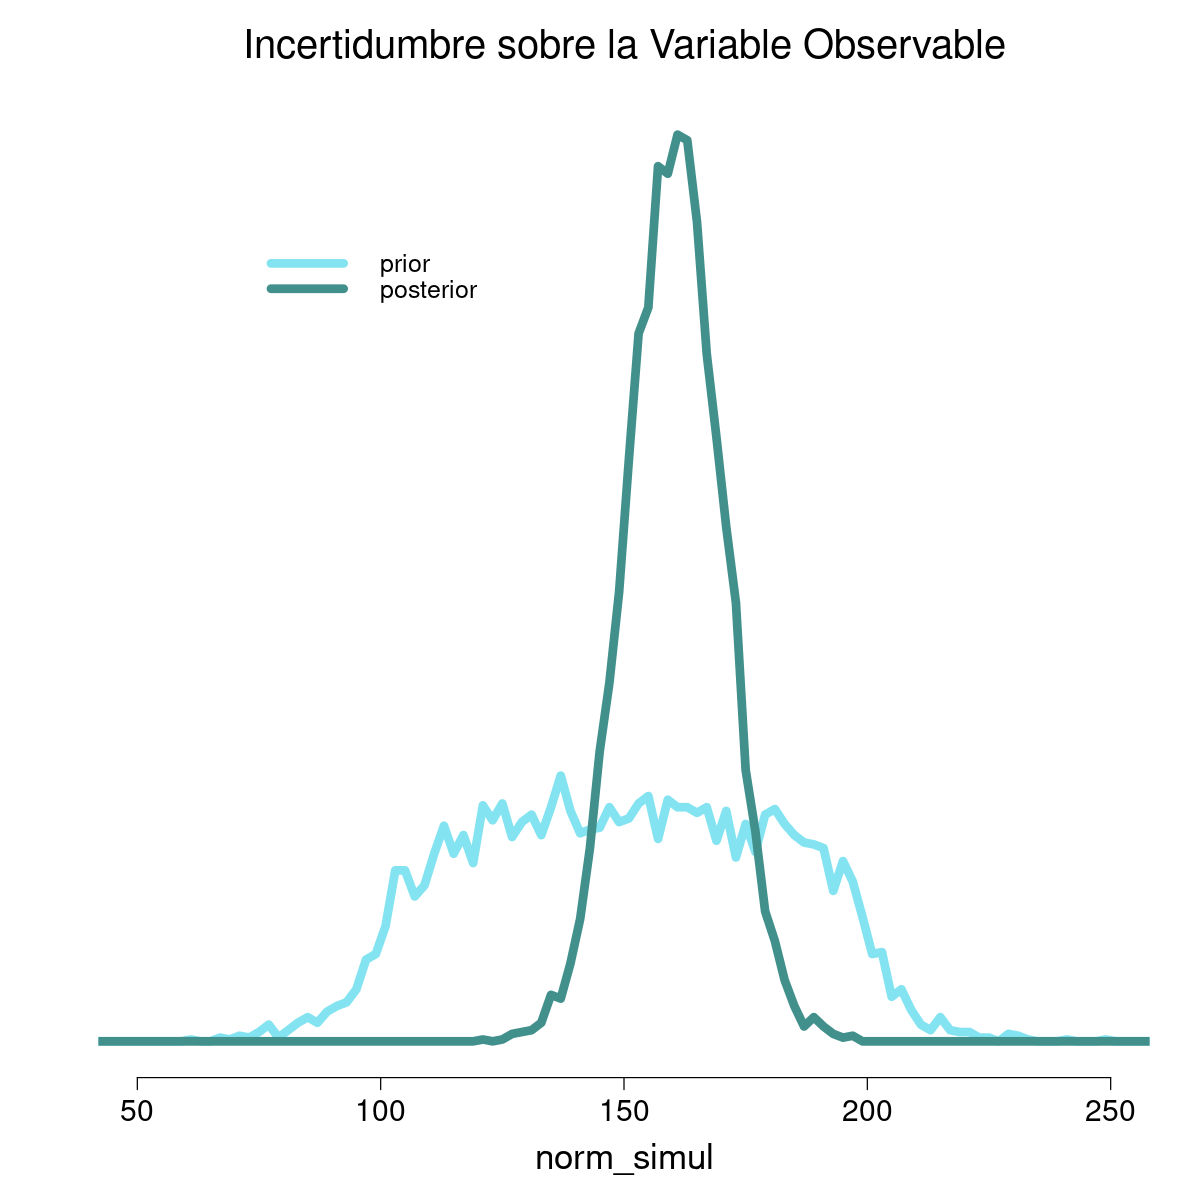

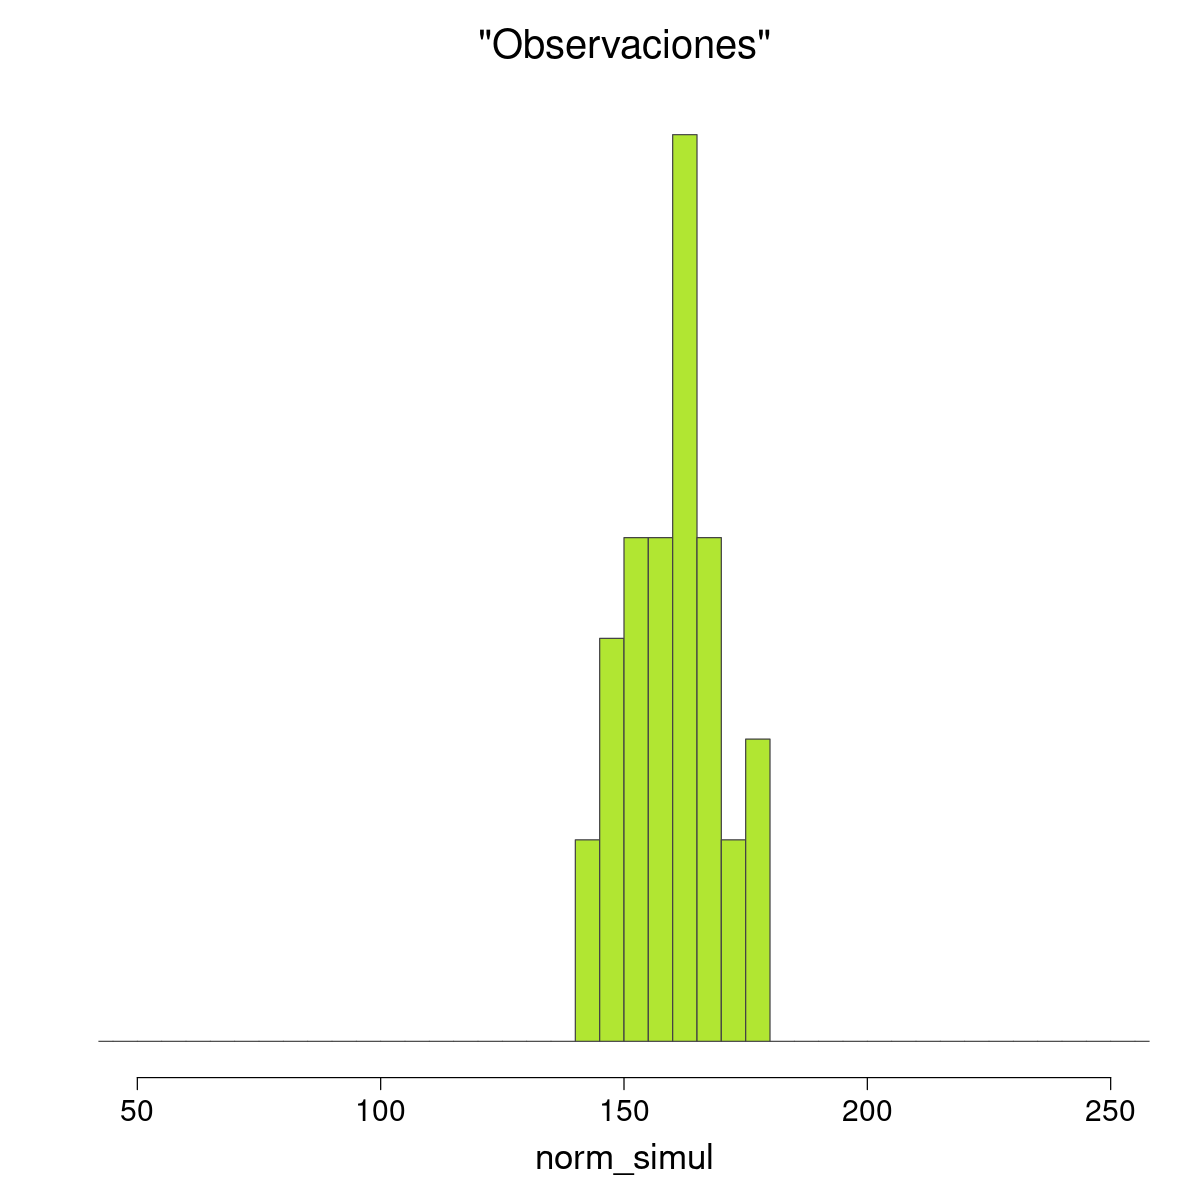

In [8]:
hist(nds$norm_simul_post,breaks=seq(0,300,2),plot=F)-> ht_norm_simul_post
hist(nds$norm_simul_prior,breaks=seq(0,300,2),plot=F)-> ht_norm_simul_prior
plot(NULL,xlim=c(50,250),ylim=c(0,max(max(ht_norm_simul_post$density),max(ht_norm_simul_prior$density))),ann=F,axes=F)
axis(1,cex.axis=1.5)
mtext('Incertidumbre sobre la Variable Observable',3,cex=2,line=1.5)
mtext('norm_simul',1,cex=1.75,line=3)
lines(ht_norm_simul_prior$mids,ht_norm_simul_prior$density,col=col_prior,lwd=7)
lines(ht_norm_simul_post$mids,ht_norm_simul_post$density,col=col_post,lwd=7)
legend(70,max(max(ht_norm_simul_post$density),max(ht_norm_simul_prior$density))*.9,
      legend=c('prior','posterior'),
      lwd=7,col=c(col_prior,col_post),
       cex=1.25,y.intersp=.5,box.lty='blank')
hist(norm_simul,xlim=c(50,250),breaks=seq(0,300,5),col=col_data,border='#444444',add=F,ann=F,axes=F)
axis(1,cex.axis=1.5)
mtext('"Observaciones"',3,cex=2,line=1.5)
mtext('norm_simul',1,cex=1.75,line=3)

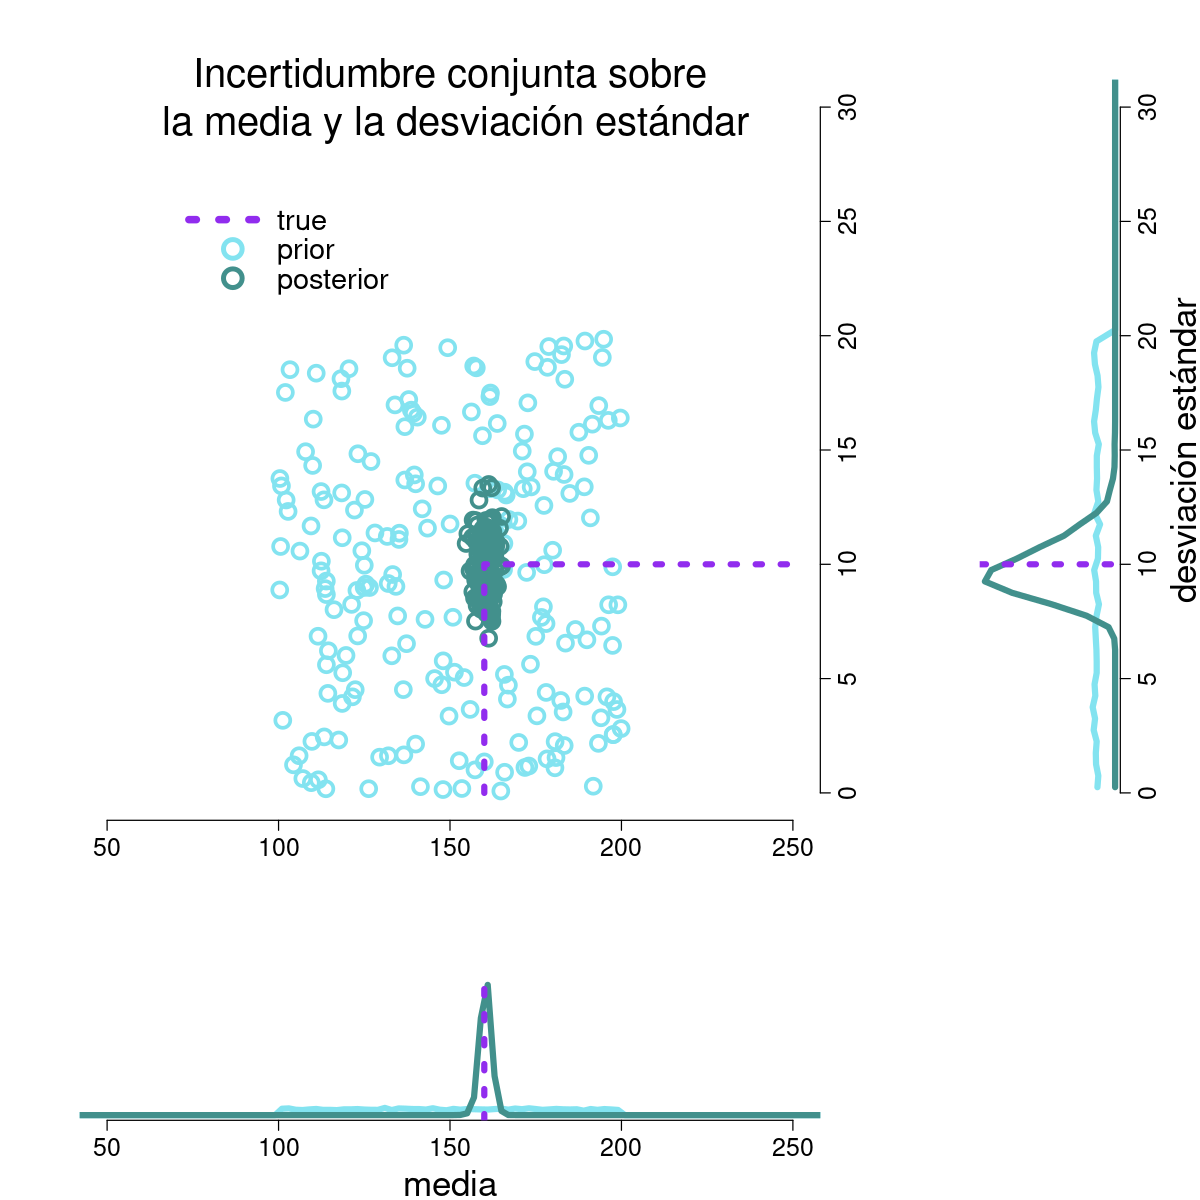

In [9]:
layout(matrix(c(1,2,3,0),ncol=2),widths = c(3,1),heights = c(3,1))
par(mar=rep(4,4))
# Joint uncertainty over mean and sd
plot(NULL,xlim=c(50,250),ylim=c(0,30),axes=F,ann=F)
indx <- sample(dim(nds$mean_post)[1],size=200)
points(nds$mean_prior[indx],nds$sd_prior[indx],col=col_prior,lwd=3,cex=2)
points(nds$mean_post[indx],nds$sd_post[indx],col=col_post,lwd=3,cex=2)
axis(1,cex.axis=1.5)
axis(4,cex.axis=1.5)
lines(x=c(rep(true_mean,2),250),
     y=c(0,rep(true_sd,2)),
     lwd=5,lty='dotted',col=col_true)
mtext('Incertidumbre conjunta sobre\n la media y la desviación estándar',3,cex=2,line=-3)
legend(70,27,
      legend=c('true','prior','posterior'),
      lwd=c(6,4,4),col=c(col_true,col_prior,col_post),
       pch=c(NA,1,1),lty=c('dotted','blank','blank'),
       cex=1.75,pt.cex=2.5,
       y.intersp=.5,x.intersp=0,
       box.lty='blank')
# Marginal over mean
plot(NULL,xlim=c(50,250),ylim=c(0,max(max(ht_mu_post$density),max(ht_mu_prior$density))),ann=F,axes=F)
axis(1,cex.axis=1.5)
mtext('media',1,cex=1.75,line=3)
lines(ht_mu_prior$mids,ht_mu_prior$density,col=col_prior,lwd=5)
lines(ht_mu_post$mids,ht_mu_post$density,col=col_post,lwd=5)
abline(v=true_mean,col=col_true,lwd=5,lty='dotted')
# Marginal over sd
plot(NULL,ylim=c(0,30),xlim=c(-max(max(ht_sd_post$density),max(ht_sd_prior$density)),0),ann=F,axes=F)
axis(4,cex.axis=1.5)
mtext('desviación estándar',4,cex=1.75,line=3)
lines(-ht_sd_prior$density,ht_sd_prior$mids,col=col_prior,lwd=5)
lines(-ht_sd_post$density,ht_sd_post$mids,col=col_post,lwd=5)
abline(h=true_sd,col=col_true,lwd=5,lty='dotted')

En general, las distribuciones **posteriores** sobre la conjunta y sobre cada marginal concentran la mayor densidad alrededor de los valores paramétricos "verdaderos" detrás del conjunto de observaciones simuladas. El modelo y las técnicas de inferencia utilizadas son consistentes en tanto que permiten recuperar los valores paramétricos correctos y explican adecuadamente las observaciones simuladas.